## Availability Price 2015-2019: $p^a$
Raw data on prices is available from [RTE](http://clients.rte-france.com/lang/fr/clients_producteurs/vie/reserve_ajustement.jsp), the French transmission system operator, and the applicable market rules are available from [ENTSO-E](https://www.entsoe.eu/network_codes/eb/fcr/), the European Network of Transmission System Operators for Electricity.
While the availability prices were historically kept constant throughout the year, they change on a weekly basis since mid-January 2017 and on a daily basis since July 2019. At this point, the pricing mechanism also changed from a pay-as-bid auction to a clearing price auction. In both cases the availability price can be considered as known to the regulation provider when she decides on her market bids. Since the introduction of time-varying pricing, prices tend to be higher in winter than in summer. Since the introduction of time-varying pricing, the average yearly availability price first *decreased* in 2017 and 2018, and then *increased* again in 2019 to 2015 and 2016 levels.

In [ ]:
# Raw Data Processing
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

df = pd.DataFrame()
# Excel files downloaded from RTE
fnames = ["Availability_2015.xlsx",\
          "Availability_2016.xlsx",\
          "Availability_2017.xlsx",\
          "Availability_2018.xlsx",\
          "Availability_2019.xlsx"]
for fname in fnames:
    df_new = pd.read_excel(fname, decimal=',')
    # rename columns
    df_new.columns = df_new.iloc[0,:]
    # remove first row
    df_new = df_new.iloc[1:]
    # consider only primary regulation
    df_new = df_new[df_new['Type de réserve']=='Réserve primaire']
    # reformat time
    t = []
    for k in range(len(df_new.index)):
        t.append(datetime.combine(df_new.iloc[k,0].date(), \
                                  datetime.strptime(df_new.iloc[k,1][0:5], '%H:%M').time()))
    df_new['Date'] = t
    df_new.drop(columns = 'Heures',inplace=True)
    df_new.rename(columns={'Date': 'Time'}, inplace = True)
    df = df.append(df_new, ignore_index=True)

In [2]:
# Data Consolidation: convert the price to €/kW/h and keep only the time and the price column
df = df[['Time','Prix de la réserve (en euros/MW/30min)']]
df.rename(columns={'Prix de la réserve (en euros/MW/30min)': 'pa'}, inplace=True)
df['pa'] = df['pa'].apply(lambda x: float(x)*2/1000)

# Data Completion: complete missing data by the nearest available data.
df.set_index('Time', inplace=True)
df = df.reindex(pd.date_range('01-01-2015 00:00:00', '12-31-2019 23:30:00', freq='30min'), method='nearest')

Plot the availability price

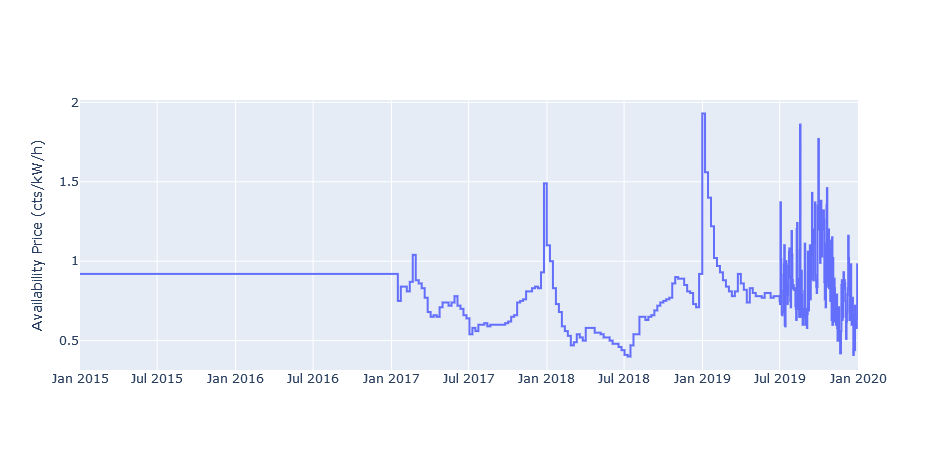

In [3]:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)
plotly.offline.iplot({
    "data": go.Scatter(x=df.index, y=round(100*df['pa'],2)),
    "layout": go.Layout(yaxis=dict(title="Availability Price (cts/kW/h)"))
})

Save data

In [5]:
df.to_hdf('pa.h5', key='df')

Examine average prices

In [9]:
df.resample('1Y').mean()

0                 pa
2015-12-31  0.009160
2016-12-31  0.009180
2017-12-31  0.007405
2018-12-31  0.006504
2019-12-31  0.008990